In [30]:
import numpy as np
import torch
import gpytorch
import torch.nn as nn
import matplotlib.pyplot as plt

# ------------------ Reproducibility ------------------
torch.manual_seed(0)
np.random.seed(0)

# ------------------ Load and Preprocess Data ------------------
data_np = np.load("spatial_temporal_data.npy")
data = data_np[50:60, 100:110, :100]  # (H=10, W=10, T=100)

data_mean = data.mean()
data_std = data.std()
data = (data - data_mean) / (data_std + 1e-8)

H, W, T = data.shape

# ======================================================
# HARD-CODED TRAINING LOCATIONS (15 points)
# - excludes (4,3)
# - includes (5,7)
# ======================================================
train_locs = np.array([
    (0, 0), (0, 4), (0, 9),
    (2, 2), (2, 7),
    (4, 0), (4, 5), (4, 9),
    (5, 7),                # <-- forced include
    (6, 2), (6, 7),
    (7, 0), (7, 5),
    (9, 4), (9, 9),
], dtype=int)

assert train_locs.shape == (15, 2)
assert not np.any(np.all(train_locs == np.array([4, 3]), axis=1)), "Oops: (4,3) is included"
assert np.any(np.all(train_locs == np.array([5, 7]), axis=1)), "Oops: (5,7) is missing"

print("Hard-coded training locations (x, y):", [tuple(loc) for loc in train_locs])

train_x_space = torch.tensor(train_locs, dtype=torch.float32)            # (15, 2)
train_x_time = torch.arange(T, dtype=torch.float32).unsqueeze(1)         # (T, 1)

# ------------------ Build Training Dataset ------------------
train_inputs, train_outputs = [], []
for i, (x_idx, y_idx) in enumerate(train_locs):
    ts = data[int(x_idx), int(y_idx), :]                                  # (T,)
    loc_tensor = train_x_space[i].repeat(T, 1)                             # (T, 2)
    train_inputs.append(torch.cat([loc_tensor, train_x_time], dim=1))      # (T, 3)
    train_outputs.append(torch.tensor(ts, dtype=torch.float32))            # (T,)

train_x = torch.cat(train_inputs, dim=0)   # (15*T, 3)
train_y = torch.cat(train_outputs, dim=0)  # (15*T,)

# Normalize inputs to [0,1]
train_x_norm = train_x.clone()
train_x_norm[:, 0] /= (H - 1)
train_x_norm[:, 1] /= (W - 1)
train_x_norm[:, 2] /= (T - 1)

# ------------------ DKL Spatial Feature Extractor ------------------
class SpatialFeatureExtractor(nn.Module):
    def __init__(self, in_dim=2, hidden_dim=32, out_dim=8):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, x_space):
        return self.net(x_space)

# ------------------ Time OUTSIDE the sum Model ------------------
class SpatioTemporalDKLModel_TimeOutsideSum(gpytorch.models.ExactGP):
    """
    Time OUTSIDE the sum (shared temporal dynamics):

        k((x,t),(x',t')) = ( sum_{r=1}^R kx^{(r)}(phi(x),phi(x')) ) * kt(t,t')

    - Spatial: shared DKL feature extractor + per-r (scaled) RBF in feature space
    - Time:    ONE shared (scaled) SpectralMixtureKernel on time
    """
    def __init__(self, train_x, train_y, likelihood, R=3, time_num_mixtures=4):
        super().__init__(train_x, train_y, likelihood)

        self.R = int(R)
        self.time_num_mixtures = int(time_num_mixtures)

        self.mean_module = gpytorch.means.ConstantMean()
        self.feature_extractor = SpatialFeatureExtractor(in_dim=2, hidden_dim=32, out_dim=8)

        self.space_kernels = nn.ModuleList()
        for _ in range(self.R):
            self.space_kernels.append(
                gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
            )

        kt_base = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=self.time_num_mixtures)
        kt_base.initialize_from_data(train_x[:, 2:3].detach(), train_y.detach())
        self.time_kernel = gpytorch.kernels.ScaleKernel(kt_base)

    def forward(self, x):
        mean_x = self.mean_module(x)

        x_space = x[..., :2]
        x_time  = x[..., 2:3]

        z = self.feature_extractor(x_space)

        Kx_sum = None
        for r in range(self.R):
            Kx_r = self.space_kernels[r](z)
            Kx_sum = Kx_r if Kx_sum is None else (Kx_sum + Kx_r)

        Kt = self.time_kernel(x_time)
        covar = Kx_sum * Kt

        return gpytorch.distributions.MultivariateNormal(mean_x, covar)

# ------------------ Train GP ------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_x_norm = train_x_norm.to(device)
train_y = train_y.to(device)

R = 2
time_num_mixtures = 4

likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model = SpatioTemporalDKLModel_TimeOutsideSum(
    train_x_norm, train_y, likelihood, R=R, time_num_mixtures=time_num_mixtures
).to(device)

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iters = 100
for i in range(training_iters):
    optimizer.zero_grad()
    output = model(train_x_norm)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()

    if (i + 1) % 10 == 0:
        print(f"Iter {i+1:3d}/{training_iters} - Loss: {loss.item():.3f}")

# ------------------ Predict on Full Grid ------------------
test_inputs = []
train_x_time_cpu = torch.arange(T, dtype=torch.float32).unsqueeze(1)

for i in range(H):
    for j in range(W):
        spatial = torch.tensor([i, j], dtype=torch.float32).repeat(T, 1)
        temporal = train_x_time_cpu
        combined = torch.cat([spatial, temporal], dim=1)
        test_inputs.append(combined)

test_x = torch.cat(test_inputs, dim=0)

test_x_norm = test_x.clone()
test_x_norm[:, 0] /= (H - 1)
test_x_norm[:, 1] /= (W - 1)
test_x_norm[:, 2] /= (T - 1)

test_x_norm = test_x_norm.to(device)

model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred_dist = likelihood(model(test_x_norm))
    pred_mean = pred_dist.mean.view(H, W, T)

pred_mean_np = pred_mean.detach().cpu().numpy()
print("Prediction shape:", pred_mean_np.shape)  # (H, W, T)


Hard-coded training locations (x, y): [(0, 0), (0, 4), (0, 9), (2, 2), (2, 7), (4, 0), (4, 5), (4, 9), (5, 7), (6, 2), (6, 7), (7, 0), (7, 5), (9, 4), (9, 9)]
Iter  10/100 - Loss: 0.455
Iter  20/100 - Loss: 0.022
Iter  30/100 - Loss: -0.439
Iter  40/100 - Loss: -0.799
Iter  50/100 - Loss: -0.806
Iter  60/100 - Loss: -1.053
Iter  70/100 - Loss: -0.797
Iter  80/100 - Loss: -1.056
Iter  90/100 - Loss: -0.841
Iter 100/100 - Loss: -0.892
Prediction shape: (10, 10, 100)


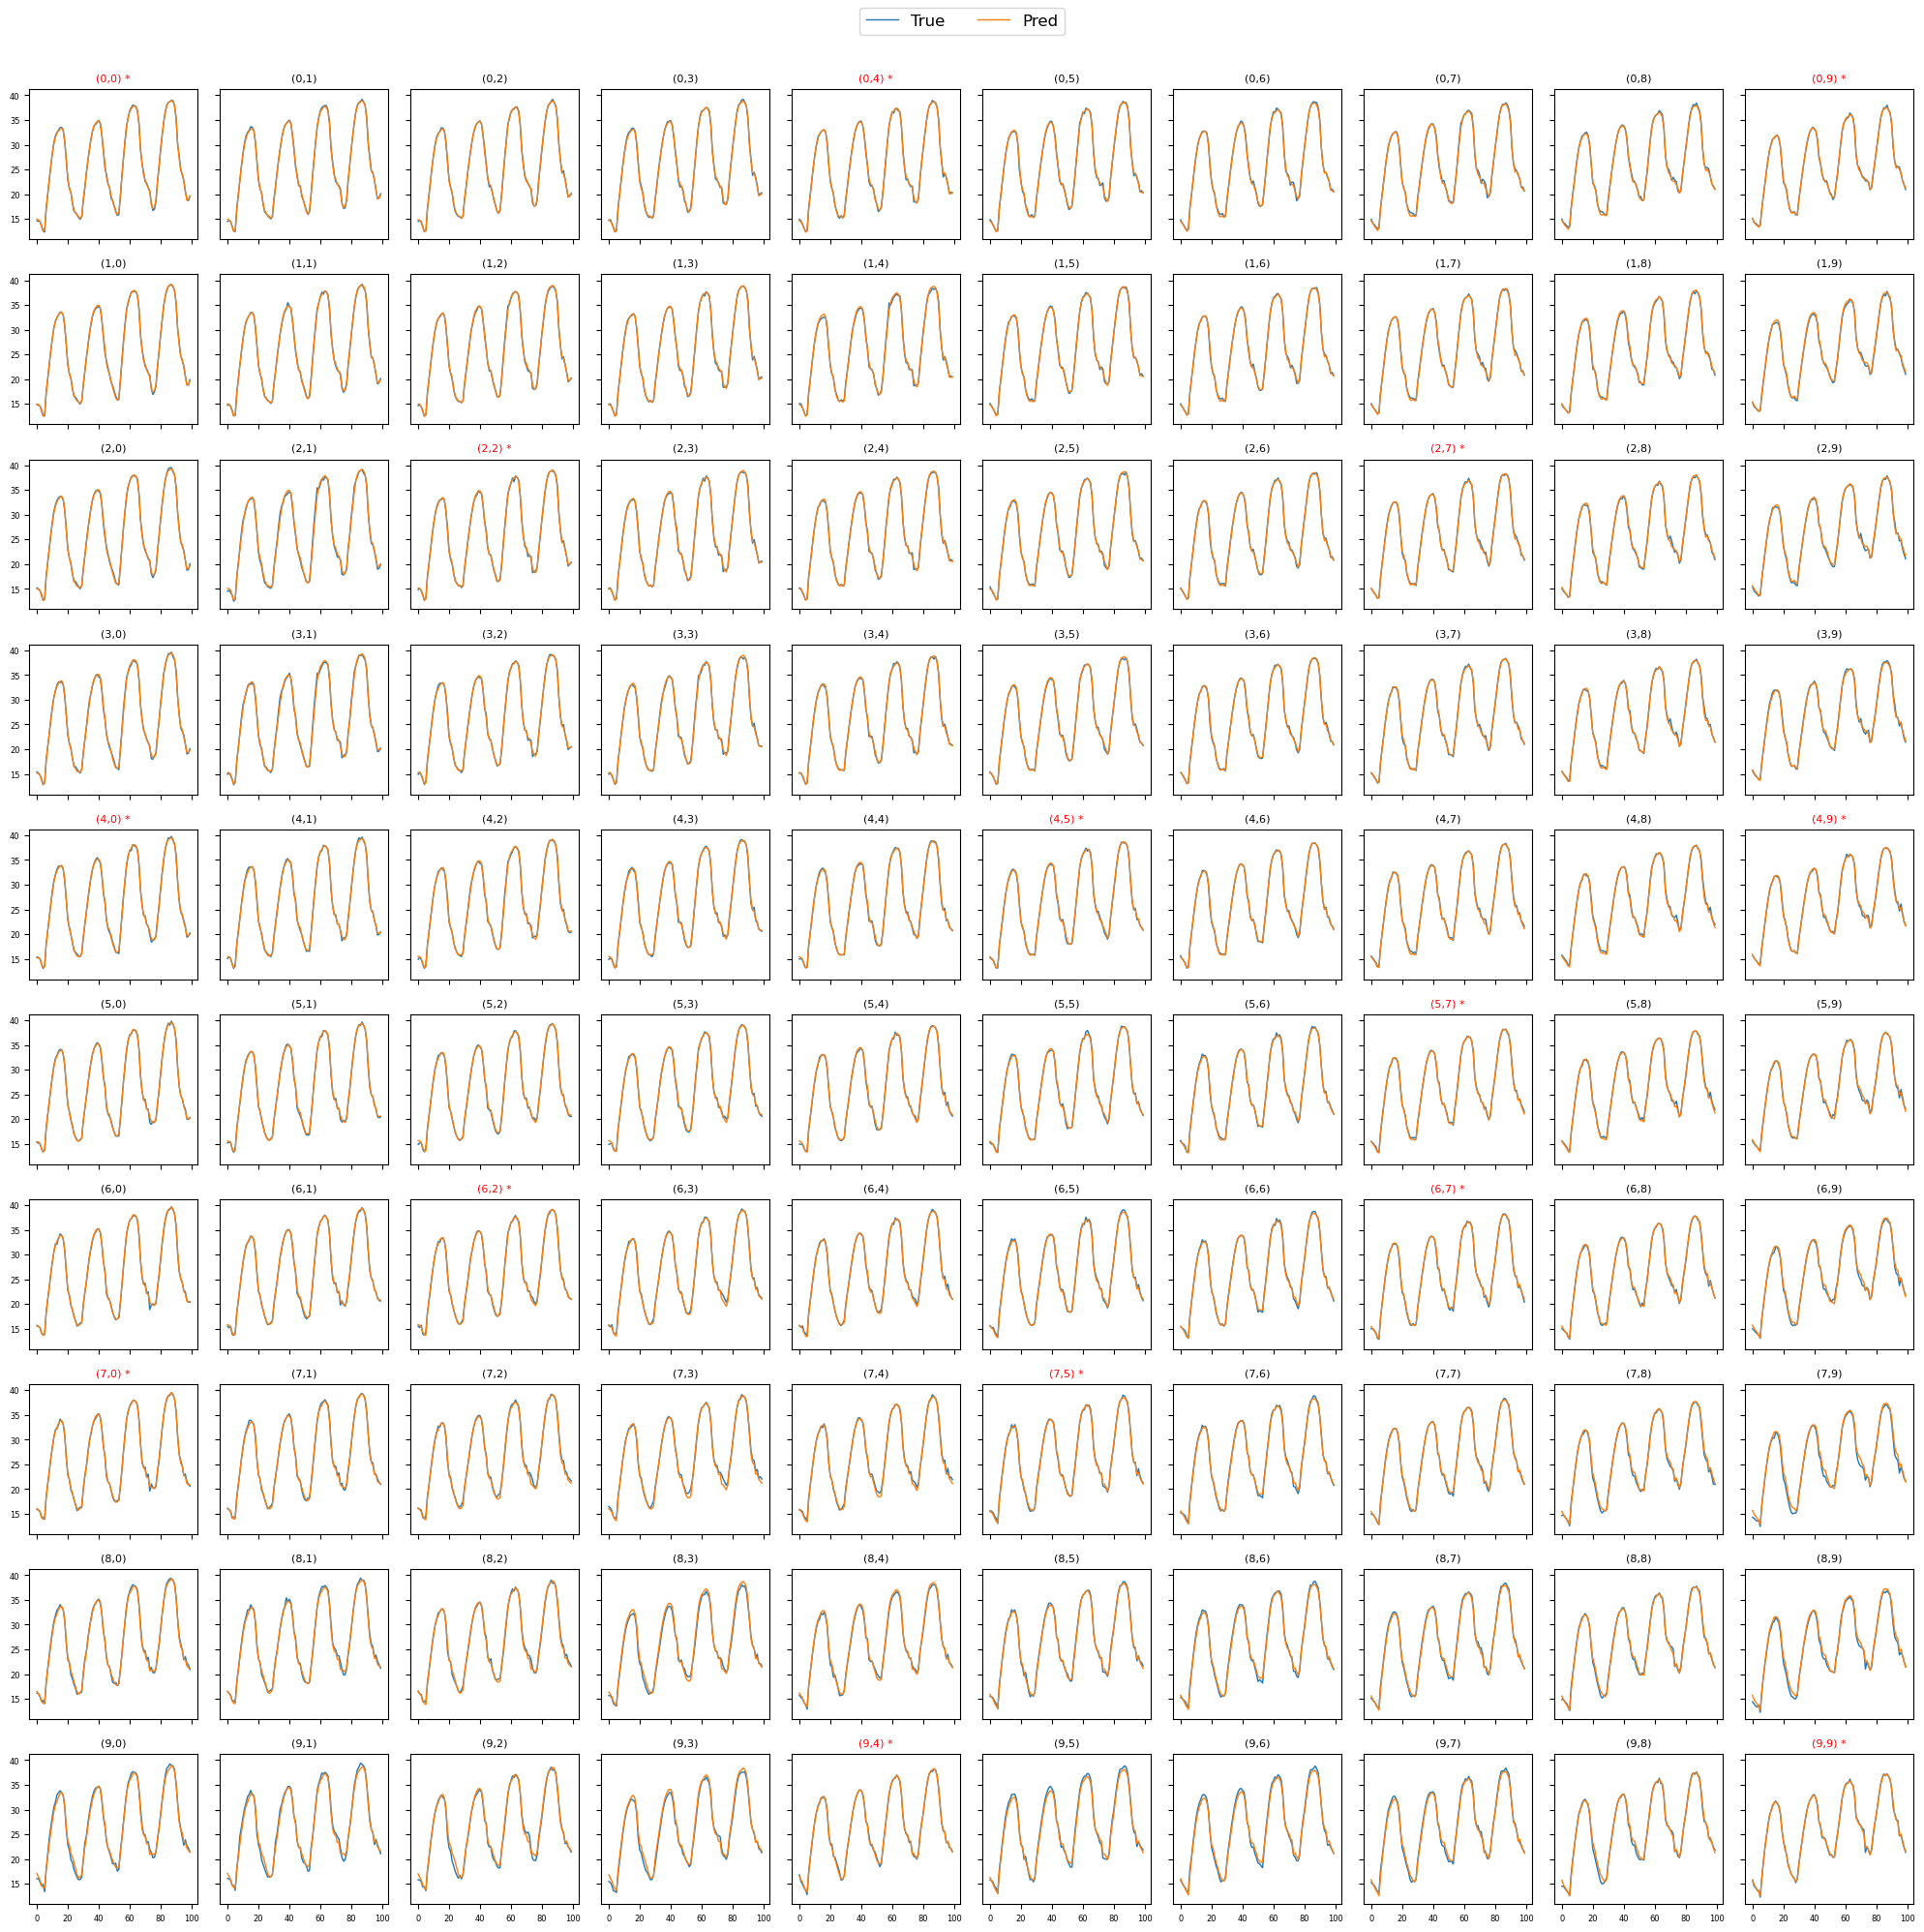

In [31]:
train_locs_set = set(map(tuple, train_locs.tolist()))

fig, axs = plt.subplots(H, W, figsize=(20, 20), sharex=True, sharey=True)

for i in range(H):
    for j in range(W):
        # de-normalize to true temperature units
        true_ts = data[i, j, :] * data_std + data_mean
        pred_ts = pred_mean_np[i, j, :] * data_std + data_mean

        axs[i, j].plot(true_ts, label="True", linewidth=1)
        axs[i, j].plot(pred_ts, label="Pred", linewidth=1)

        is_train = (i, j) in train_locs_set
        title = f"({i},{j})" + (" *" if is_train else "")
        axs[i, j].set_title(title, fontsize=8, color="red" if is_train else "black")
        axs[i, j].tick_params(labelsize=6)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

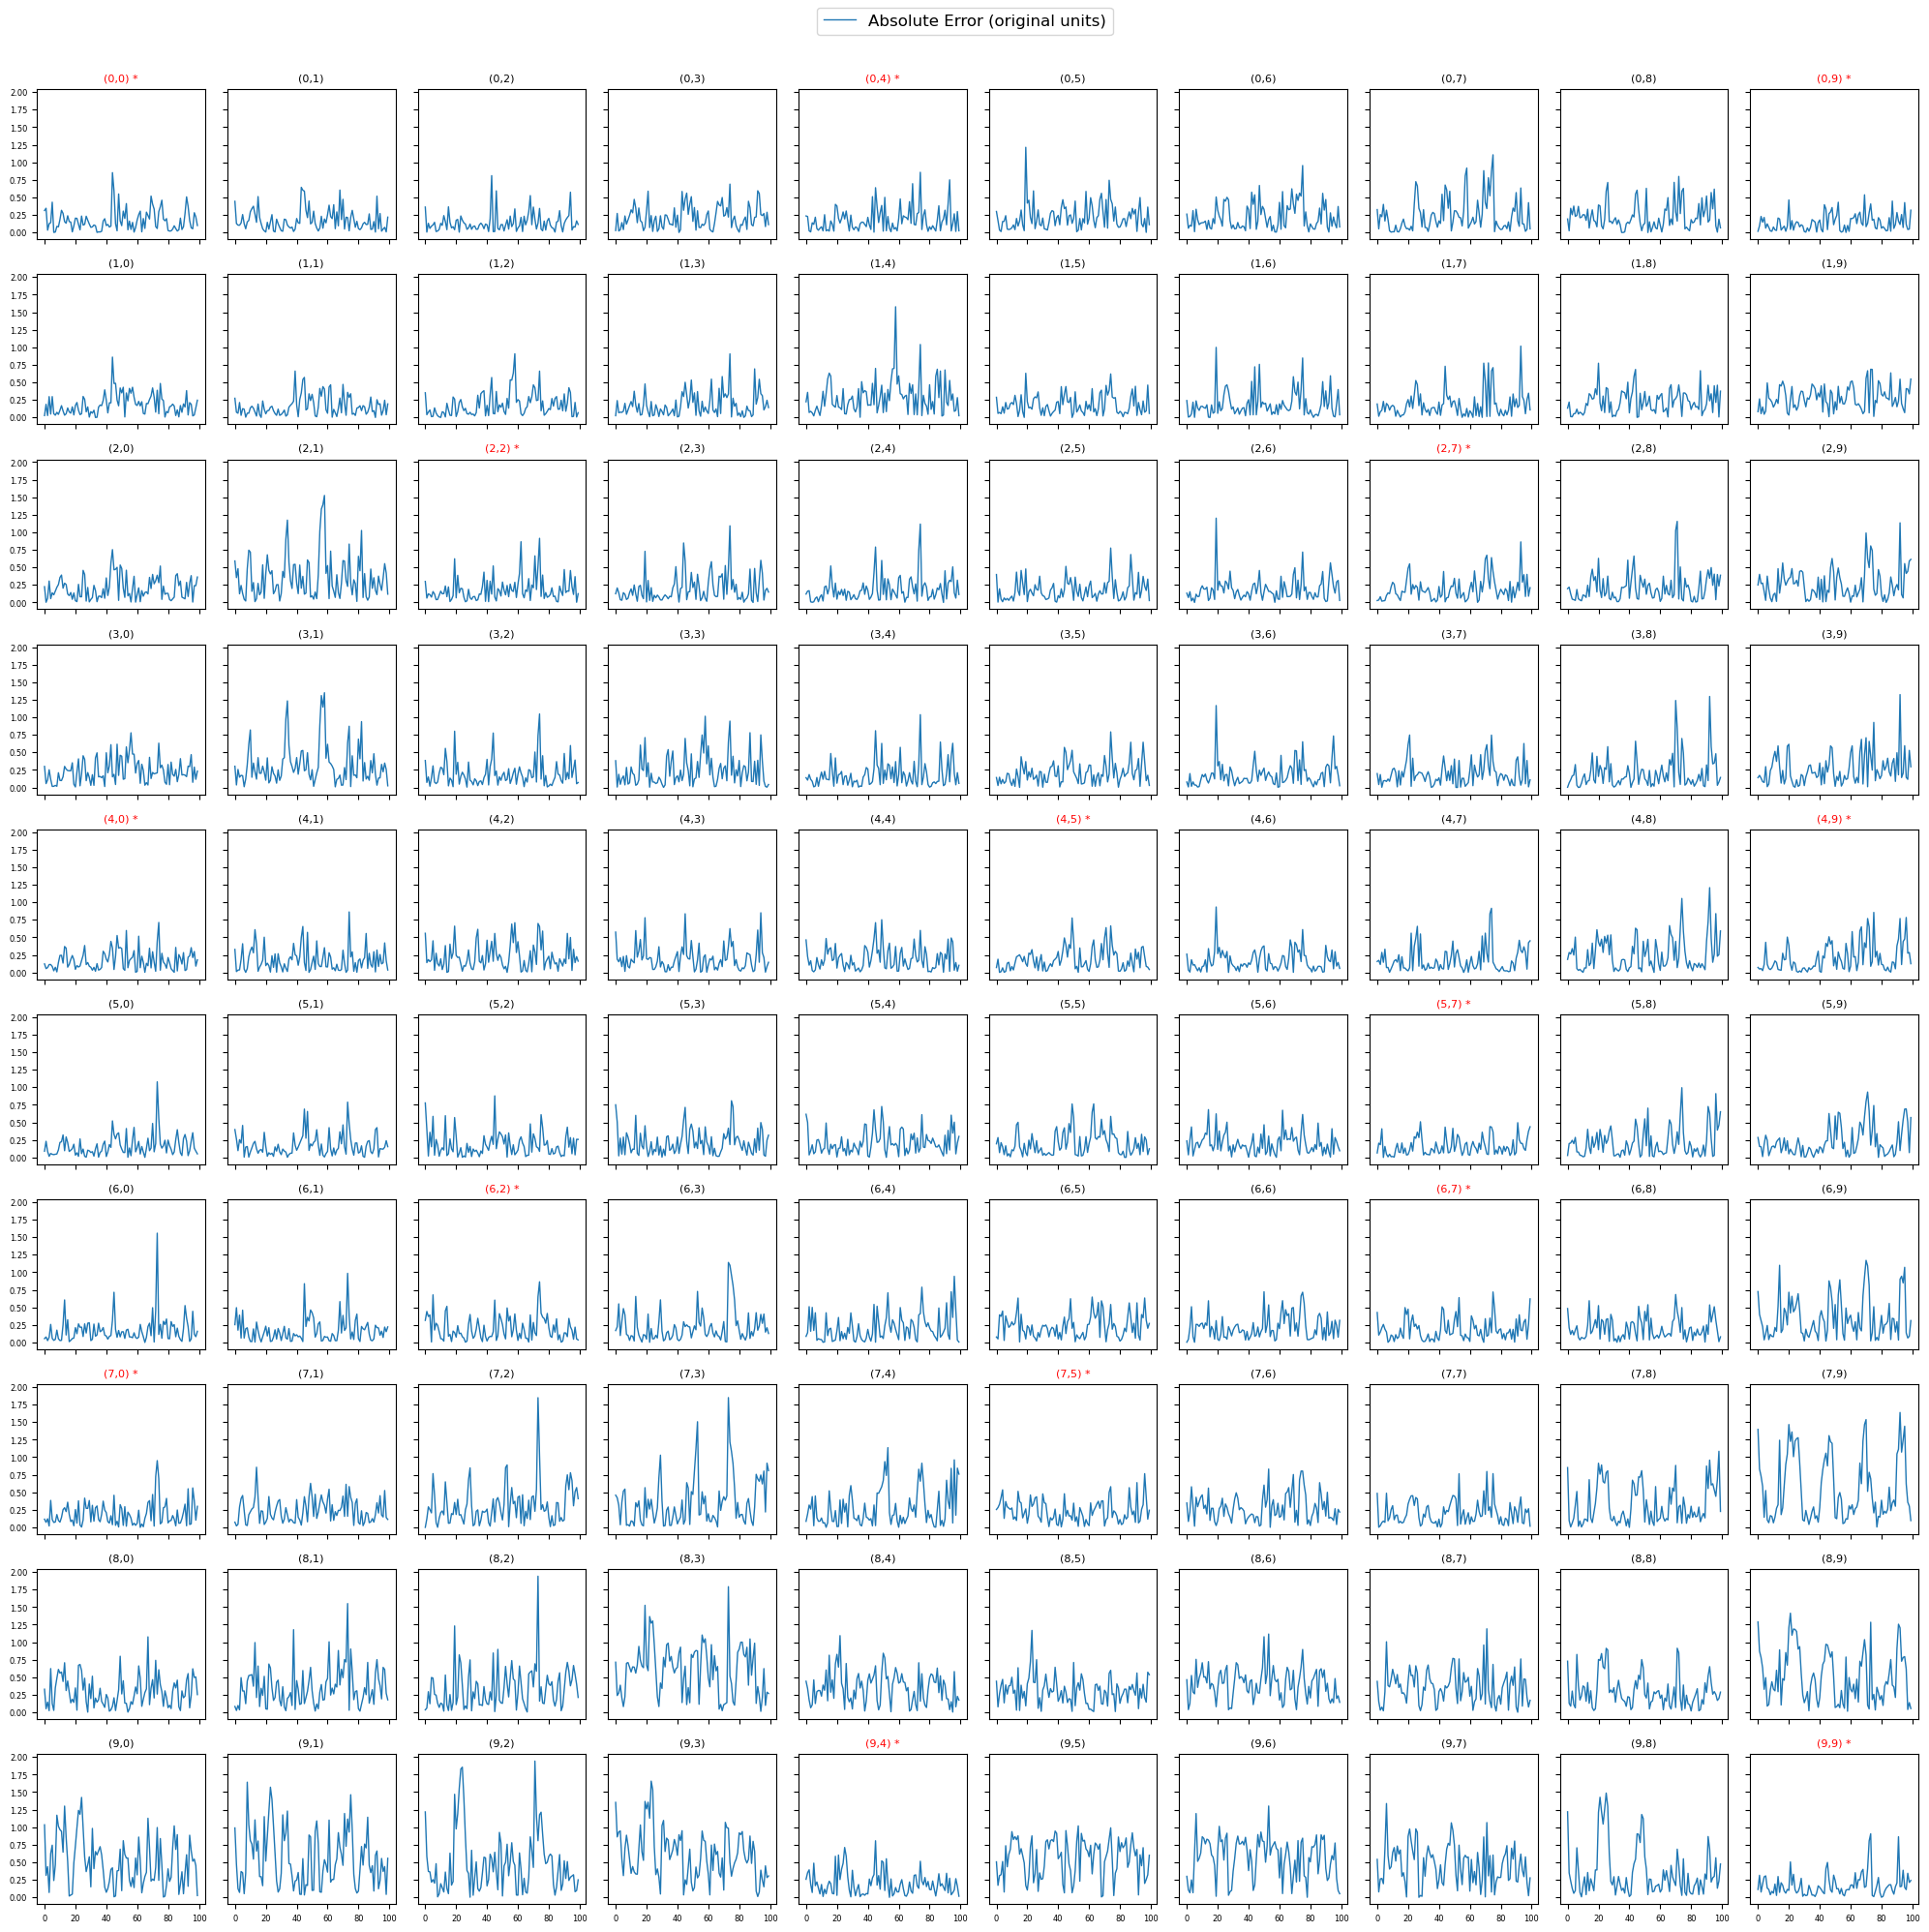

In [32]:
# Absolute error (denormalized) time series for all locations
train_locs_set = set(map(tuple, train_locs.tolist()))

fig, axs = plt.subplots(H, W, figsize=(20, 20), sharex=True, sharey=True)

for i in range(H):
    for j in range(W):
        # Absolute error in normalized space → convert to original units
        abs_err = torch.abs(
            pred_mean[i, j, :] - torch.tensor(data[i, j, :], device=pred_mean.device)
        ) * data_std

        abs_err = abs_err.detach().cpu().numpy()

        axs[i, j].plot(abs_err, linewidth=1, color="tab:blue")

        is_train = (i, j) in train_locs_set
        axs[i, j].set_title(
            f"({i},{j})" + (" *" if is_train else ""),
            fontsize=8,
            color="red" if is_train else "black"
        )
        axs[i, j].tick_params(labelsize=6)

# Shared legend
fig.legend(
    ["Absolute Error (original units)"],
    loc="upper center",
    ncol=1,
    fontsize=12
)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

Location (0,1): 0 points exceed 1.0
Location (5,9): 0 points exceed 1.0
Location (8,2): 2 points exceed 1.0


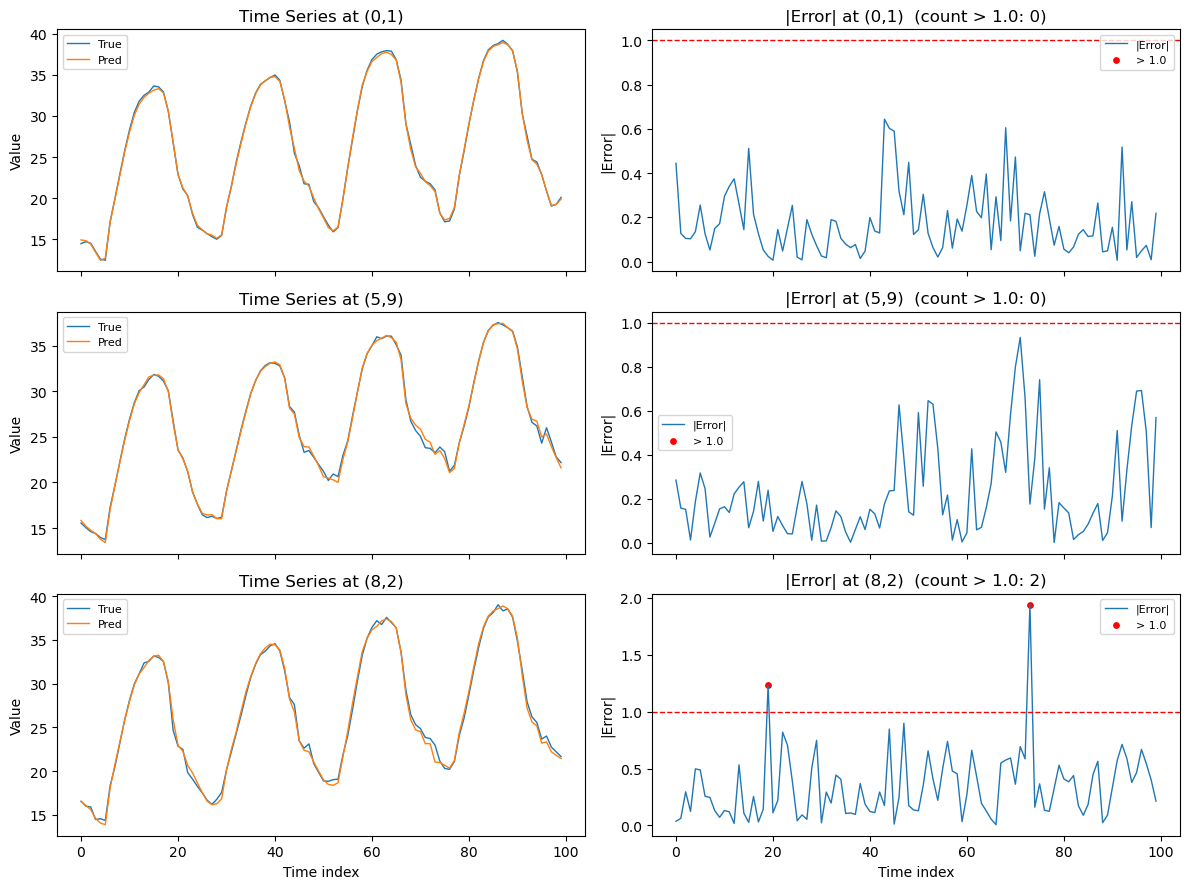

In [33]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Locations to inspect
locations = [(0, 1), (5, 9), (8, 2)]
threshold = 1.0

fig, axs = plt.subplots(len(locations), 2, figsize=(12, 3 * len(locations)), sharex=True)

for row, (i, j) in enumerate(locations):
    # ---- Denormalize true & predicted time series ----
    true_ts = data[i, j, :] * data_std + data_mean
    pred_ts = pred_mean[i, j, :].detach().cpu().numpy() * data_std + data_mean

    # ---- Absolute error (denormalized) ----
    abs_err = np.abs(pred_ts - true_ts)

    # ---- Count exceedances ----
    exceed_idx = abs_err > threshold
    num_exceed = np.sum(exceed_idx)

    print(f"Location ({i},{j}): {num_exceed} points exceed {threshold}")

    # ---- Plot true vs pred ----
    axs[row, 0].plot(true_ts, label="True", linewidth=1)
    axs[row, 0].plot(pred_ts, label="Pred", linewidth=1)
    axs[row, 0].set_title(f"Time Series at ({i},{j})")
    axs[row, 0].set_ylabel("Value")
    axs[row, 0].legend(fontsize=8)

    # ---- Plot absolute error ----
    axs[row, 1].plot(abs_err, label="|Error|", linewidth=1)
    axs[row, 1].axhline(threshold, color="red", linestyle="--", linewidth=1)

    # Mark exceedances
    axs[row, 1].scatter(
        np.where(exceed_idx)[0],
        abs_err[exceed_idx],
        color="red",
        s=15,
        label="> 1.0"
    )

    axs[row, 1].set_title(f"|Error| at ({i},{j})  (count > 1.0: {num_exceed})")
    axs[row, 1].set_ylabel("|Error|")
    axs[row, 1].legend(fontsize=8)

axs[-1, 0].set_xlabel("Time index")
axs[-1, 1].set_xlabel("Time index")

plt.tight_layout()
plt.show()
